In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # FFFFF

# Data loading
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

# Auxiliary functions
from torch.utils.tensorboard import SummaryWriter  # Used for Tensorboard logging
import os
import numpy as np
import matplotlib.pyplot as plt
from math import floor, ceil
import datetime

import json

from dataset_semseg import SupermarketSemSeg

import matplotlib.patches as mpatches
import matplotlib.cm as cm

from sklearn.metrics import f1_score   

# Segmentación de imagen mediante arquitectura U-Net

In [ ]:
PATH_ROOT = os.path.join('.')
# Ruta para datos:
PATH_DATA = os.path.join(PATH_ROOT, 'data')
# Ruta para modelos:
PATH_MODELS = os.path.join(PATH_ROOT, 'reports', 'models')
# Ruta para resultados:
PATH_RESULTS = os.path.join(PATH_ROOT, 'reports', 'results')
# Ruta para ejecuciones:
PATH_RUNS = os.path.join(PATH_ROOT, 'reports', 'runs')

In [ ]:
# Para cada sesión creamos un directorio nuevo, a partir de la fecha y hora de su ejecución:
date = datetime.datetime.now()
test_name = str(date.year) + '_' + str(date.month) + '_' +  str(date.day) + '__' + str(date.hour) + '_' + str(date.minute)
print('Nombre del directorio de pruebas: {}'.format(test_name))
models_folder = os.path.join(PATH_MODELS, test_name)
try:
    os.makedirs(models_folder)
except:
    print(f'Folder {models_folder} already existed.')
results_folder = os.path.join(PATH_RESULTS, test_name)
try:
    os.makedirs(results_folder)
except:
    print(f'Folder {results_folder} already existed.')
runs_folder = os.path.join(PATH_RUNS, test_name)
try:
    os.makedirs(runs_folder)
except:
    print(f'Folder {runs_folder} already existed.')


Nombre del directorio de pruebas: 2025_12_3__9_30


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)   

cuda


## Definición del modelo

Como vamos a repetir la estructura de Convolución, Convolución, pooling, hacemos una clase para ello

In [ ]:
class DoubleConv(nn.Module):
    """
    Conv3x3 -> ReLU -> Conv3x3 -> ReLU
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


In [ ]:
class Down(nn.Module):
    """
    MaxPool2x2 -> DoubleConv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x


In [ ]:
class Up(nn.Module):
    """
    UpConv2x2 -> concat con skip -> DoubleConv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)  # in_channels = (up_out + skip)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([skip, x], dim=1)
        x = self.conv(x)
        return x


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=11, base_ch=64, depth=4):
        super().__init__()
        self.num_classes = num_classes
        self.depth = depth
        
        self.inc = DoubleConv(in_channels, base_ch)
        
        # Encoder
        self.downs = nn.ModuleList()
        for i in range(depth):
            ch_in = base_ch * (2**i)      # Canales de entrada: 64, 128, 256, 512
            ch_out = base_ch * (2**(i+1)) # Canales de salida: 128, 256, 512, 1024
            self.downs.append(Down(ch_in, ch_out))
        
        # Decoder
        self.ups = nn.ModuleList()
        for i in range(depth):
            ch_in = base_ch * (2**(depth-i))    # Canales de entrada: 1024, 512, 256, 128
            ch_out = base_ch * (2**(depth-i-1)) # Canales de salida: 512, 256, 128, 64
            self.ups.append(Up(ch_in, ch_out))
        
        self.outc = nn.Conv2d(base_ch, num_classes, kernel_size=1)
    
    def forward(self, x):
        # guardamos skip connections
        skips = [self.inc(x)]
        for down in self.downs:
            skips.append(down(skips[-1]))
        
        # usamos skip connections en reversa
        x = skips[-1]
        for i, up in enumerate(self.ups):
            x = up(x, skips[-(i+2)])
        
        return self.outc(x)

## Carga de Datos

Cargamos los dos conjuntos de datos (elegir)

10 clases

In [ ]:
clase = "train"
root_images_train = f"./dataset_res_144_192_10classes/{clase}/images/"
root_masks_train = f"./dataset_res_144_192_10classes/{clase}/masks/"

clase = "test"
root_images_test = f"./dataset_res_144_192_10classes/{clase}/images/"
root_masks_test = f"./dataset_res_144_192_10classes/{clase}/masks/"

dataset_train = SupermarketSemSeg(images_dir=root_images_train, masks_dir=root_masks_train, include_filenames=True)
dataset_test = SupermarketSemSeg(images_dir=root_images_test, masks_dir=root_masks_test, include_filenames=True)

num_classes = 11

Todas las clases

In [ ]:
clase = "train"
root_images_train = f"./dataset_res_144_192/{clase}/images/"
root_masks_train = f"./dataset_res_144_192/{clase}/masks/"

clase = "test"
root_images_test = f"./dataset_res_144_192/{clase}/images/"
root_masks_test = f"./dataset_res_144_192/{clase}/masks/"

dataset_train = SupermarketSemSeg(images_dir=root_images_train, masks_dir=root_masks_train, include_filenames=True)
dataset_test = SupermarketSemSeg(images_dir=root_images_test, masks_dir=root_masks_test, include_filenames=True)

num_classes = 61

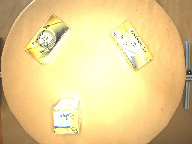

In [ ]:
x = dataset_train.__getitem__(400)
mask = x["mask"]
dataset_train._read_image(p = x["image_path"])

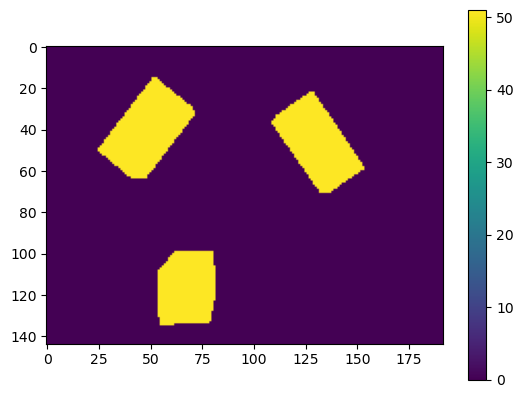

In [ ]:
plt.imshow(mask.numpy())
plt.colorbar()
plt.show()

In [ ]:
total_size = len(dataset_train)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset = random_split(
    dataset_train, 
    [train_size, val_size], 
    generator=generator
)

batch_size = 4  # Tamaño de lotes
num_workers = 0  # Controla cuántos procesos cargan datos en paralelo (lo dejaremos a 0 para ahorrar recursos)

In [ ]:
train_loader = DataLoader(
    dataset=train_dataset,      
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    dataset=val_dataset,        
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

test_loader = DataLoader(
    dataset=dataset_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)


In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device, writer=None, scheduler=None):

    train_losses = []
    val_losses = []

    num_classes = model.num_classes

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        train_preds = []
        train_masks = []

        # --------- TRAIN ---------
        for batch in train_loader:
            imgs = batch["image"].to(device)          # (B, 3, H, W)
            masks = batch["mask"].long().to(device)   # (B, H, W)

            optimizer.zero_grad()

            outputs = model(imgs)                     # (B, C, H, W)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = outputs.argmax(1)                 # (B, H, W)
            running_correct += (preds == masks).sum().item()
            running_total += masks.numel()

            train_preds.append(preds)
            train_masks.append(masks)

        avg_train_loss = running_loss / len(train_loader)
        train_pixel_acc = running_correct / running_total
        train_losses.append(avg_train_loss)
        
        train_f1 = f1_score(
            torch.cat([t.flatten().cpu() for t in train_masks]),
            torch.cat([t.flatten().cpu() for t in train_preds]),
            average='macro',
            zero_division=0
        )

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Train Acc: {train_pixel_acc:.4f} - Train F1: {train_f1:.4f}")
        if writer is not None:
            writer.add_scalar('train/loss', avg_train_loss, epoch)
            writer.add_scalar('train/pixel_acc', train_pixel_acc, epoch)
            writer.add_scalar('train/f1_score', train_f1, epoch)

        # --------- VALIDACIÓN ---------
        model.eval()
        running_val_loss = 0.0
        running_val_correct = 0
        running_val_total = 0

        val_preds = []
        val_masks = []

        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):

                imgs = batch["image"].to(device)
                masks = batch["mask"].long().to(device)

                outputs = model(imgs)
                loss = criterion(outputs, masks)
                running_val_loss += loss.item()

                preds = outputs.argmax(1)
                running_val_correct += (preds == masks).sum().item()
                running_val_total += masks.numel()

                val_preds.append(preds)
                val_masks.append(masks)

                # ---- LOG DE IMÁGENES SOLO UNA VEZ POR EPOCH ----
                if writer is not None and batch_idx == 0 and epoch % 2 == 0:
                    imgs_cpu = imgs[:4].cpu()
                    masks_cpu = masks[:4].cpu()
                    preds_cpu = preds[:4].cpu()

                    mean_vec = mean.view(1, -1, 1, 1)
                    std_vec  = std.view(1, -1, 1, 1)
                    fig, axes = plt.subplots(4, 3, figsize=(10, 10))
                    for i in range(4):
                        img_denorm = (imgs_cpu[i].unsqueeze(0) * std_vec + mean_vec).squeeze(0)    # (C,H,W)
                        img_np = img_denorm.permute(1, 2, 0).numpy()
                        img_np = np.clip(img_np, 0, 1)

                        orig  = masks_cpu[i].numpy()
                        pred  = preds_cpu[i].numpy()

                        axes[i, 0].imshow(img_np)
                        axes[i, 0].set_title("Imagen")
                        axes[i, 0].axis("off")

                        axes[i, 1].imshow(img_np)
                        axes[i, 1].imshow(orig, cmap='tab10', alpha=0.8, vmin=0, vmax=num_classes-1)
                        axes[i, 1].set_title("GT")
                        axes[i, 1].axis("off")

                        axes[i, 2].imshow(img_np)
                        axes[i, 2].imshow(pred, cmap='tab10', alpha=0.8, vmin=0, vmax=num_classes-1)
                        axes[i, 2].set_title("Pred")
                        axes[i, 2].axis("off")

                    plt.tight_layout()
                    writer.add_figure("val/overlay", fig, epoch)
                    plt.close(fig)


        avg_val_loss = running_val_loss / len(val_loader)
        val_pixel_acc = running_val_correct / running_val_total
        val_losses.append(avg_val_loss)

        val_f1 = f1_score(
            torch.cat([t.flatten().cpu() for t in val_masks]),
            torch.cat([t.flatten().cpu() for t in val_preds]),
            average='macro',
            zero_division=0
        )

        print(f"           Val Loss: {avg_val_loss:.4f} - Val Pixel Acc: {val_pixel_acc:.4f} - Val F1: {val_f1:.4f}")
        
        if scheduler is not None:
            scheduler.step(avg_val_loss)
            
        # TensorBoard: scalars de VAL
        if writer is not None:
            writer.add_scalar('val/loss', avg_val_loss, epoch)
            writer.add_scalar('val/pixel_acc', val_pixel_acc, epoch)
            writer.add_scalar('val/f1_score', val_f1, epoch)

        # Tensorboard: Histogramas de pesos y gradientes
        if writer is not None:
            for name, p in model.named_parameters():
                if p.requires_grad:
                    writer.add_histogram(f'params/{name}', p.detach().cpu(), epoch)
                    if p.grad is not None:
                        writer.add_histogram(f'grads/{name}', p.grad.detach().cpu(), epoch)

    return train_losses, val_losses

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device, writer=None, scheduler=None):

    train_losses = []
    val_losses = []

    num_classes = model.num_classes

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        train_preds = []
        train_masks = []

        # --------- TRAIN ---------
        for batch in train_loader:
            imgs = batch["image"].to(device)          # (B, 3, H, W)
            masks = batch["mask"].long().to(device)   # (B, H, W)

            optimizer.zero_grad()

            outputs = model(imgs)                     # (B, C, H, W)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = outputs.argmax(1)                 # (B, H, W)
            running_correct += (preds == masks).sum().item()
            running_total += masks.numel()

            train_preds.append(preds)
            train_masks.append(masks)

        avg_train_loss = running_loss / len(train_loader)
        train_pixel_acc = running_correct / running_total
        train_losses.append(avg_train_loss)
        
        train_f1 = f1_score(
            torch.cat([t.flatten().cpu() for t in train_masks]),
            torch.cat([t.flatten().cpu() for t in train_preds]),
            average='macro',
            zero_division=0
        )

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Train Acc: {train_pixel_acc:.4f} - Train F1: {train_f1:.4f}")
        if writer is not None:
            writer.add_scalar('train/loss', avg_train_loss, epoch)
            writer.add_scalar('train/pixel_acc', train_pixel_acc, epoch)
            writer.add_scalar('train/f1_score', train_f1, epoch)

        # --------- VALIDACIÓN ---------
        model.eval()
        running_val_loss = 0.0
        running_val_correct = 0
        running_val_total = 0

        val_preds = []
        val_masks = []

        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):

                imgs = batch["image"].to(device)
                masks = batch["mask"].long().to(device)

                outputs = model(imgs)
                loss = criterion(outputs, masks)
                running_val_loss += loss.item()

                preds = outputs.argmax(1)
                running_val_correct += (preds == masks).sum().item()
                running_val_total += masks.numel()

                val_preds.append(preds)
                val_masks.append(masks)

                # ---- LOG DE IMÁGENES SOLO UNA VEZ POR EPOCH ----
                if writer is not None and batch_idx == 0 and epoch % 2 == 0:
                    imgs_cpu = imgs[:4].cpu()
                    masks_cpu = masks[:4].cpu()
                    preds_cpu = preds[:4].cpu()
                    
                    # Nuevo código para usar las imágenes normalizadas directamente
                    fig, axes = plt.subplots(4, 3, figsize=(10, 10))
                    for i in range(4):
                        # Convertir a formato compatible con matplotlib (H, W, C) y numpy
                        # Nota: En este punto, `imgs_cpu` contiene las imágenes normalizadas (C, H, W)
                        img_np = imgs_cpu[i].permute(1, 2, 0).numpy()

                        orig  = masks_cpu[i].numpy()
                        pred  = preds_cpu[i].numpy()

                        axes[i, 0].imshow(img_np)
                        axes[i, 0].set_title("Imagen (Normalizada)") # Título ajustado para reflejar que no está desnormalizada
                        axes[i, 0].axis("off")

                        axes[i, 1].imshow(img_np)
                        axes[i, 1].imshow(orig, cmap='tab10', alpha=0.8, vmin=0, vmax=num_classes-1)
                        axes[i, 1].set_title("GT")
                        axes[i, 1].axis("off")

                        axes[i, 2].imshow(img_np)
                        axes[i, 2].imshow(pred, cmap='tab10', alpha=0.8, vmin=0, vmax=num_classes-1)
                        axes[i, 2].set_title("Pred")
                        axes[i, 2].axis("off")

                    plt.tight_layout()
                    writer.add_figure("val/overlay", fig, epoch)
                    plt.close(fig)


        avg_val_loss = running_val_loss / len(val_loader)
        val_pixel_acc = running_val_correct / running_val_total
        val_losses.append(avg_val_loss)

        val_f1 = f1_score(
            torch.cat([t.flatten().cpu() for t in val_masks]),
            torch.cat([t.flatten().cpu() for t in val_preds]),
            average='macro',
            zero_division=0
        )

        print(f"           Val Loss: {avg_val_loss:.4f} - Val Pixel Acc: {val_pixel_acc:.4f} - Val F1: {val_f1:.4f}")
        
        if scheduler is not None:
            scheduler.step(avg_val_loss)
            
        # TensorBoard: scalars de VAL
        if writer is not None:
            writer.add_scalar('val/loss', avg_val_loss, epoch)
            writer.add_scalar('val/pixel_acc', val_pixel_acc, epoch)
            writer.add_scalar('val/f1_score', val_f1, epoch)

        # Tensorboard: Histogramas de pesos y gradientes
        if writer is not None:
            for name, p in model.named_parameters():
                if p.requires_grad:
                    writer.add_histogram(f'params/{name}', p.detach().cpu(), epoch)
                    if p.grad is not None:
                        writer.add_histogram(f'grads/{name}', p.grad.detach().cpu(), epoch)

    return train_losses, val_losses

In [ ]:
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    with torch.no_grad():
        for batch in test_loader:
            imgs = batch["image"].to(device)
            masks = batch["mask"].long().to(device)

            outputs = model(imgs)
            loss = criterion(outputs, masks)
            running_loss += loss.item()

            preds = outputs.argmax(1)
            running_correct += (preds == masks).sum().item()
            running_total += masks.numel()
            
    avg_loss = running_loss / len(test_loader)
    pixel_acc = running_correct / running_total

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Pixel Accuracy: {pixel_acc:.4f}")

    return avg_loss, pixel_acc


# Comienzo del entrenamiento

Utilizaremos el optimizador Adam por su robustez porque es el estandar en el sector para este tipo de problemas. Podriamos probar y otros compararlos, pero como este funciona correctamente optaremos por mejorar el modelo posteriormente en otros aspectos que tengan mayor impacto.

In [ ]:
model = UNet(
    in_channels=3,
    num_classes=num_classes,
    base_ch=64,
    depth = 4
).to(device)

criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter(log_dir=runs_folder)

train_losses, val_losses = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=50,
    device=device,
    scheduler=None,
    writer=writer
)

Epoch 1/50 - Train Loss: 0.6591 - Train Acc: 0.9095 - Train F1: 0.0210
           Val Loss: 0.3506 - Val Pixel Acc: 0.9186 - Val F1: 0.0260
Epoch 2/50 - Train Loss: 1.9049 - Train Acc: 0.8978 - Train F1: 0.0213
           Val Loss: 0.4002 - Val Pixel Acc: 0.9127 - Val F1: 0.0156
Epoch 3/50 - Train Loss: 0.3896 - Train Acc: 0.9114 - Train F1: 0.0190
           Val Loss: 0.3642 - Val Pixel Acc: 0.9160 - Val F1: 0.0198
Epoch 4/50 - Train Loss: 0.3533 - Train Acc: 0.9146 - Train F1: 0.0274
           Val Loss: 0.3186 - Val Pixel Acc: 0.9195 - Val F1: 0.0337
Epoch 5/50 - Train Loss: 0.3253 - Train Acc: 0.9170 - Train F1: 0.0450
           Val Loss: 0.3851 - Val Pixel Acc: 0.9170 - Val F1: 0.0354
Epoch 6/50 - Train Loss: 0.3469 - Train Acc: 0.9185 - Train F1: 0.0624
           Val Loss: 0.3029 - Val Pixel Acc: 0.9243 - Val F1: 0.0594
Epoch 7/50 - Train Loss: 0.2821 - Train Acc: 0.9265 - Train F1: 0.1181
           Val Loss: 0.2484 - Val Pixel Acc: 0.9315 - Val F1: 0.1410
Epoch 8/50 - Train L

Guardamos el modelo

In [ ]:
torch.save(model.state_dict(), 'model.pth')
torch.save(optimizer.state_dict(), 'optimizer.pth')

Cargamos el modelo

In [ ]:
model = UNet(
    in_channels=3,
    num_classes=num_classes,
    base_ch=64
).to(device)

model.load_state_dict(torch.load('model.pth', map_location=device))

optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer.load_state_dict(torch.load('optimizer.pth', map_location=device))

# Elegir modo según lo que vayamos a hacer:
model.eval()  # Para evaluación
# model.train()  # Para continuar entrenamiento

In [48]:
test(model, test_loader, criterion, device)

Test Loss: 1.4497
Test Pixel Accuracy: 0.7848


(1.4497263260682425, 0.7847532371238426)

In [26]:
def leer_mapeado(ruta):
    with open(ruta, 'r') as f:
        data = json.load(f)
    clases = {}
    for i in range(len(data)):
        clases[data[i]['index']] = data[i]['name']
    return clases
if num_classes == 11:
    mapeado_clases = leer_mapeado('dataset_res_144_192_10classes/label_mapping_10classes.json')
else:
    mapeado_clases = leer_mapeado('dataset_res_144_192/label_mapping.json')

/tmp/ipykernel_263181/2793469223.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('nipy_spectral', num_classes)


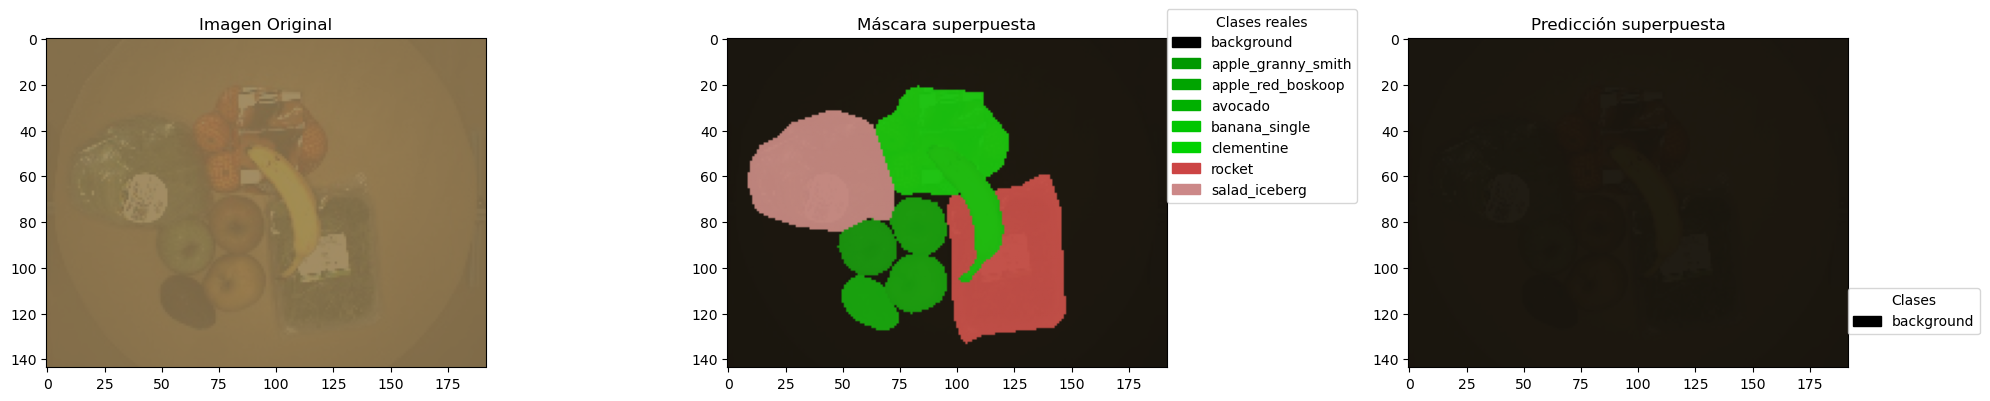

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.cm as cm

def ver_prediccion(indice, test = True,  alpha = 0.8, num_classes=None):
    # Asegurar num_classes correcto
    if num_classes is None:
        num_classes = 61
    ejemplo = dataset_test[indice] if test else dataset_train[indice]
    x = ejemplo["image"]
    # Dispositivo del modelo
    model_device = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        pred = model(x.to(model_device).unsqueeze(0)).argmax(1).squeeze().cpu().numpy()
    mask = ejemplo["mask"].numpy()
    mask = np.where(mask >= num_classes, 0, mask)
    # Colormap discreto con N=num_classes
    cmap = cm.get_cmap('nipy_spectral', num_classes)
    # Denormalizar imagen para visualizar correctamente
    img = x.cpu().permute(1, 2, 0).numpy()
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    axes[0].imshow(img)
    axes[0].set_title('Imagen Original')
    axes[1].imshow(img)
    axes[1].imshow(mask, cmap=cmap, vmin=0, vmax=num_classes-1, alpha=alpha)
    axes[1].set_title('Máscara superpuesta')
    axes[2].imshow(img)
    axes[2].imshow(pred, cmap=cmap, vmin=0, vmax=num_classes-1, alpha=alpha)
    axes[2].set_title('Predicción superpuesta')

    # Leyendas
    clases_mask = np.unique(mask)
    patches_mask = [mpatches.Patch(color=cmap(int(i)), label=mapeado_clases.get(int(i), str(int(i)))) for i in clases_mask]
    axes[1].legend(handles=patches_mask, loc=[1,0.5], title='Clases reales')
    clases_presentes = np.unique(pred)
    patches = [mpatches.Patch(color=cmap(int(i)), label=mapeado_clases.get(int(i), str(int(i)))) for i in clases_presentes]
    plt.legend(handles=patches, loc=[1,0.1], title='Clases')
    plt.tight_layout()
    plt.show()

ver_prediccion(900, test=True, num_classes=num_classes)

In [23]:
def test_comp(model, test_loader, criterion, device, num_classes):
    model.eval()
    running_loss = 0.0
    
    # Inicializamos la matriz de confusión (Predicción vs Verdad)
    confusion_matrix = torch.zeros(num_classes, num_classes, device=device)

    with torch.no_grad():
        for batch in test_loader:
            imgs = batch["image"].to(device)
            masks = batch["mask"].long().to(device) 

            outputs = model(imgs)
            loss = criterion(outputs, masks)
            running_loss += loss.item()

            preds = outputs.argmax(1) # [Batch, Height, Width]

            # --- Actualización de Métricas ---
            # Aplanamos los tensores para comparar píxel a píxel
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)

            # Calculamos índices únicos para la matriz de confusión 
            idx = masks_flat * num_classes + preds_flat
            
            # Contamos ocurrencias 
            count = torch.bincount(idx, minlength=num_classes**2)
            
            # Reformateamos a matriz cuadrada y acumulamos
            confusion_matrix += count.reshape(num_classes, num_classes)

    # --- Cálculos Finales ---
    
    # 1. Global Pixel Accuracy
    # Suma de la diagonal (aciertos) / Suma total
    total_pixels = confusion_matrix.sum()
    correct_pixels = confusion_matrix.diag().sum()
    pixel_acc = correct_pixels / total_pixels

    # 2. Accuracy por Clase (Recall)
    # Diagonal / Suma de cada fila (Total de píxeles reales de esa clase)
    # Agregamos 1e-6 para evitar división por cero si una clase no aparece
    class_acc = confusion_matrix.diag() / (confusion_matrix.sum(1) + 1e-6)

    # 3. Intersection over Union (IoU) por Clase
    # IoU = Intersección / (Area Real + Area Predicha - Intersección)
    intersection = confusion_matrix.diag()
    union = confusion_matrix.sum(1) + confusion_matrix.sum(0) - intersection
    iou_per_class = intersection / (union + 1e-6)
    mean_iou = iou_per_class.mean()

    # --- Reporte ---
    avg_loss = running_loss / len(test_loader)

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Global Pixel Accuracy: {pixel_acc:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    print("-" * 30)
    for i, (acc, iou) in enumerate(zip(class_acc, iou_per_class)):
        print(f"Clase {i}: Acc: {acc:.4f} | IoU: {iou:.4f}")

    # Retornamos un diccionario con todo para que sea fácil de usar
    metrics = {
        "loss": avg_loss,
        "pixel_acc": pixel_acc.item(),
        "mean_iou": mean_iou.item(),
        "class_acc": class_acc.cpu().numpy(),
        "class_iou": iou_per_class.cpu().numpy()
    }
    
    return metrics

In [49]:
test_comp(model, test_loader, criterion, device,61)

Test Loss: 1.4497
Global Pixel Accuracy: 0.7848
Mean IoU: 0.0129
------------------------------
Clase 0: Acc: 1.0000 | IoU: 0.7848
Clase 1: Acc: 0.0000 | IoU: 0.0000
Clase 2: Acc: 0.0000 | IoU: 0.0000
Clase 3: Acc: 0.0000 | IoU: 0.0000
Clase 4: Acc: 0.0000 | IoU: 0.0000
Clase 5: Acc: 0.0000 | IoU: 0.0000
Clase 6: Acc: 0.0000 | IoU: 0.0000
Clase 7: Acc: 0.0000 | IoU: 0.0000
Clase 8: Acc: 0.0000 | IoU: 0.0000
Clase 9: Acc: 0.0000 | IoU: 0.0000
Clase 10: Acc: 0.0000 | IoU: 0.0000
Clase 11: Acc: 0.0000 | IoU: 0.0000
Clase 12: Acc: 0.0000 | IoU: 0.0000
Clase 13: Acc: 0.0000 | IoU: 0.0000
Clase 14: Acc: 0.0000 | IoU: 0.0000
Clase 15: Acc: 0.0000 | IoU: 0.0000
Clase 16: Acc: 0.0000 | IoU: 0.0000
Clase 17: Acc: 0.0000 | IoU: 0.0000
Clase 18: Acc: 0.0000 | IoU: 0.0000
Clase 19: Acc: 0.0000 | IoU: 0.0000
Clase 20: Acc: 0.0000 | IoU: 0.0000
Clase 21: Acc: 0.0000 | IoU: 0.0000
Clase 22: Acc: 0.0000 | IoU: 0.0000
Clase 23: Acc: 0.0000 | IoU: 0.0000
Clase 24: Acc: 0.0000 | IoU: 0.0000
Clase 25: Acc:

{'loss': 1.4497263321942753,
 'pixel_acc': 0.7847532033920288,
 'mean_iou': 0.012864804826676846,
 'class_acc': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'class_iou': array([0.78475314, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.     